# Boston Housing Dataset

### Предметная область
Недвижимость в пригородах Бостона

### Источник данных
Набор данных Boston Housing  
https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data

**Первоисточник:**  
Харрисон, Д. и Рубинфельд, Д. Л. «Гедонистические цены и спрос на чистый воздух»  
J. Environ. Economics & Management, т. 5, стр. 81–102, 1978 г.

### Характер данных
Реальные данные

#  ИНФОРМАЦИЯ ОБ АТРИБУТАХ ДАТАСЕТА BOSTON HOUSING

## Входные данные (14 атрибутов):

| № | Атрибут | Описание | Единицы измерения |
|---|---------|----------|-------------------|
| 1 | **CRIM** | Уровень преступности на душу населения в городе | случаи на душу населения |
| 2 | **ZN** | Доля жилых земель, отнесенных к категории участков площадью более 25 000 кв. футов | % |
| 3 | **INDUS** | Доля нерозничных коммерческих акров в городе | % |
| 4 | **CHAS** | Фиктивная переменная реки Чарльз (1 - если участок граничит с рекой; 0 - в противном случае) | бинарная (0/1) |
| 5 | **NOX** | Концентрация оксидов азота | частиц на 10 миллионов |
| 6 | **RM** | Среднее количество комнат в жилище | комнат |
| 7 | **AGE** | Доля единиц жилья, занимаемых владельцами, построенных до 1940 года | % |
| 8 | **DIS** | Взвешенные расстояния до пяти бостонских центров занятости | условные единицы |
| 9 | **RAD** | Индекс доступности к радиальным магистралям | индекс |
| 10 | **TAX** | Ставка налога на имущество с полной стоимостью | $ за 10 000 стоимости |
| 11 | **PTRATIO** | Соотношение учеников и учителей по городам | учеников на учителя |
| 12 | **B** | Результат уравнения B = 1000(Bk - 0,63)², где Bk — доля чернокожих по городам | расчётный показатель |
| 13 | **LSTAT** | Процент населения с низким статусом | % |
| 14 | **MEDV** | Медианная стоимость домов, занимаемых владельцами | тысячи долларов США |

---

##  Типы данных:
- **Все атрибуты** представлены в числовом виде
- **CHAS** - единственная категориальная (бинарная) переменная
- **Остальные атрибуты** - непрерывные числовые переменные

---

###  Примечание:
Датасет содержит информацию о 506 районах Бостона и используется для прогнозирования стоимости жилья на основе различных социально-экономических и физических характеристик.

#  Выполнение работы

## Выбор целевого атрибута

В данном наборе данных единственным подходящим целевым атрибутом является:

**MEDV** (Median Value of Owner-Occupied Homes in $1000's)

- Это непрерывная числовая переменная
- Она представляет стоимость недвижимости — классический пример регрессионной задачи
- Все остальные признаки (CRIM, ZN, INDUS, ...) используются для прогнозирования MEDV

## Импорт библиотек

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve, 
                           classification_report, confusion_matrix)
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('boston.csv')

## Оценка сбалансированности классов

In [15]:
df['PRICE_CLASS'] = pd.cut(df['MEDV'], 
                         bins=[0, 17, 21, 25, 50], 
                         labels=['Low', 'Medium', 'High', 'Very High'])

class_distribution = df['PRICE_CLASS'].value_counts()
print("Распределение классов в целевом атрибуте PRICE_CLASS:")
print(class_distribution)

Распределение классов в целевом атрибуте PRICE_CLASS:
PRICE_CLASS
High         133
Low          127
Very High    124
Medium       122
Name: count, dtype: int64


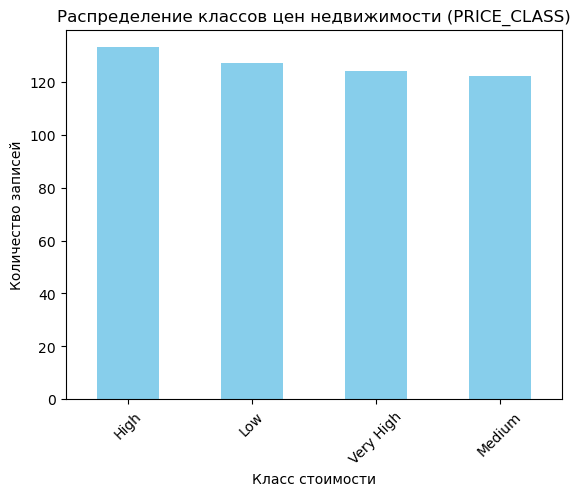

In [16]:
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Распределение классов цен недвижимости (PRICE_CLASS)')
plt.xlabel('Класс стоимости')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()

### Классы сбалансированы

Классы демонстрируют высокую степень сбалансированности. Разброс в количестве наблюдений между категориями минимален, что создает благоприятные условия для построения моделей классификации. 

## Подготовка данных 

#### **Преобразование категореальных меток в числа**

In [22]:
X = df.drop(['MEDV', 'PRICE_CLASS'], axis=1)
y = df['PRICE_CLASS']

#### **Разделение на признаки и целевую переменную**

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#### **Разделение на обучающую и тестовую выборки**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, 
                                                    random_state=42, stratify=y_encoded)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Классы: {le.classes_}")

Размер тренировочной выборки: (354, 13)
Размер тестовой выборки: (152, 13)
Классы: ['High' 'Low' 'Medium' 'Very High']


#### **Масштабирование признаков с помощью StandardScaler**

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение и оценка предсказаний kNN

Оптимальное k: 8
Accuracy: 0.7039
Precision: 0.7426
Recall: 0.7039
F1-score: 0.7079


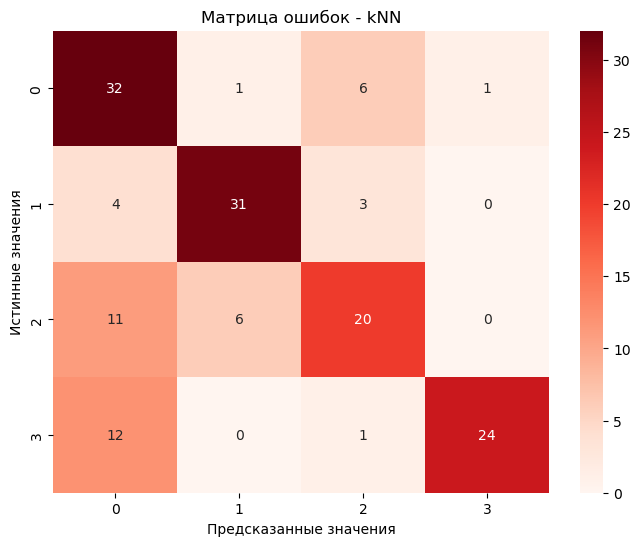

In [43]:
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]
print(f"Оптимальное k: {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_knn, average='weighted'):.4f}")

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds')
plt.title('Матрица ошибок - kNN')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

#### **Алгоритм дерева решений**

Лучшие параметры: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Лучшая accuracy: 0.6188
Accuracy: 0.6908
Precision: 0.6951
Recall: 0.6908
F1-score: 0.6921


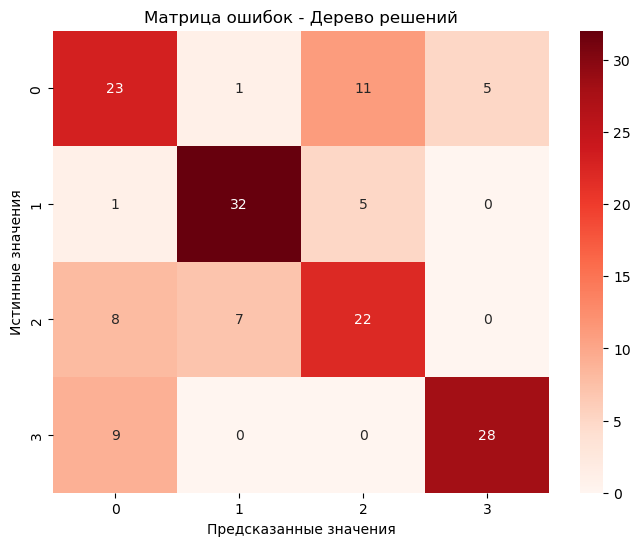

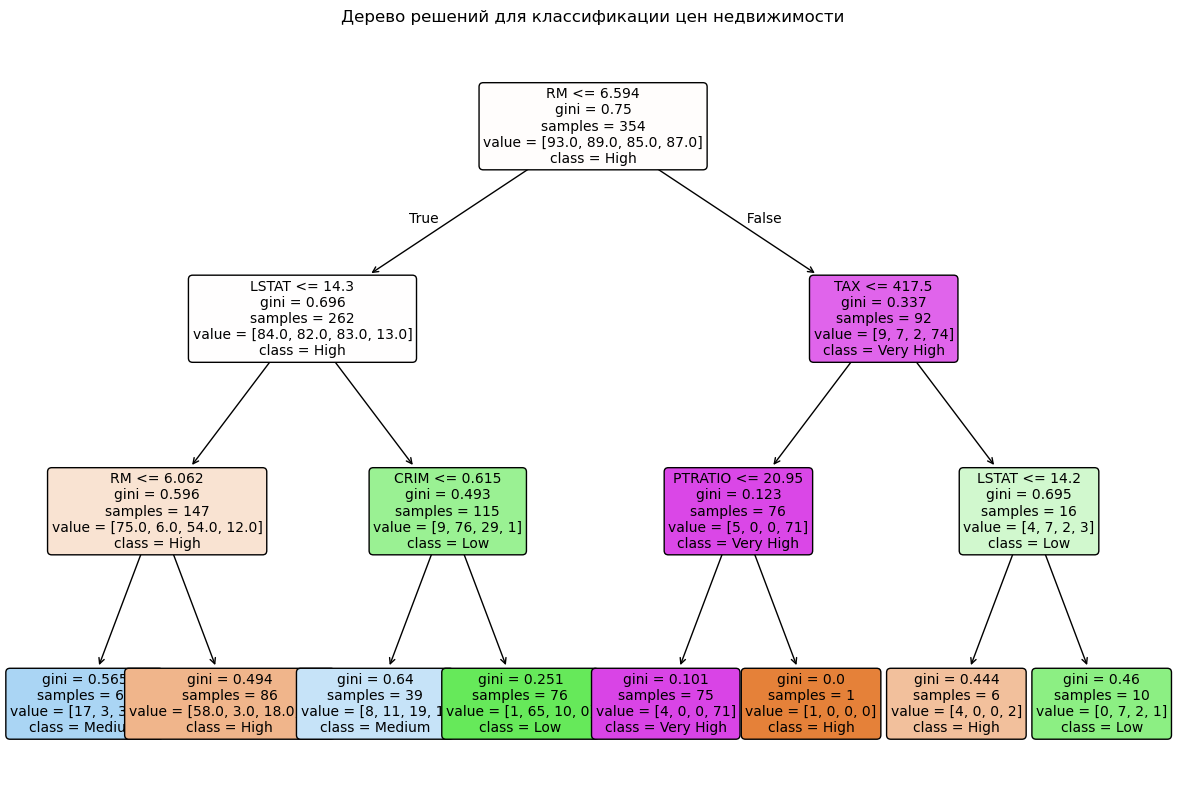

In [52]:
param_grid = {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая accuracy: {grid_search.best_score_:.4f}")

dt_best = grid_search.best_estimator_
dt_best.fit(X_train, y_train)
y_pred_dt = dt_best.predict(X_test)
y_prob_dt = dt_best.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_dt, average='weighted'):.4f}")

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds')
plt.title('Матрица ошибок - Дерево решений')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

plt.figure(figsize=(15, 10))
plot_tree(dt_best, feature_names=X.columns, class_names=le.classes_, 
          filled=True, rounded=True, fontsize=10)
plt.title('Дерево решений для классификации цен недвижимости')
plt.show()

## Сравнение результатов классификации

,Metric,kNN,Decision Tree
0,Accuracy,0.703947,0.690789
1,Precision,0.742642,0.695092
2,Recall,0.703947,0.690789
3,F1-score,0.707851,0.692120


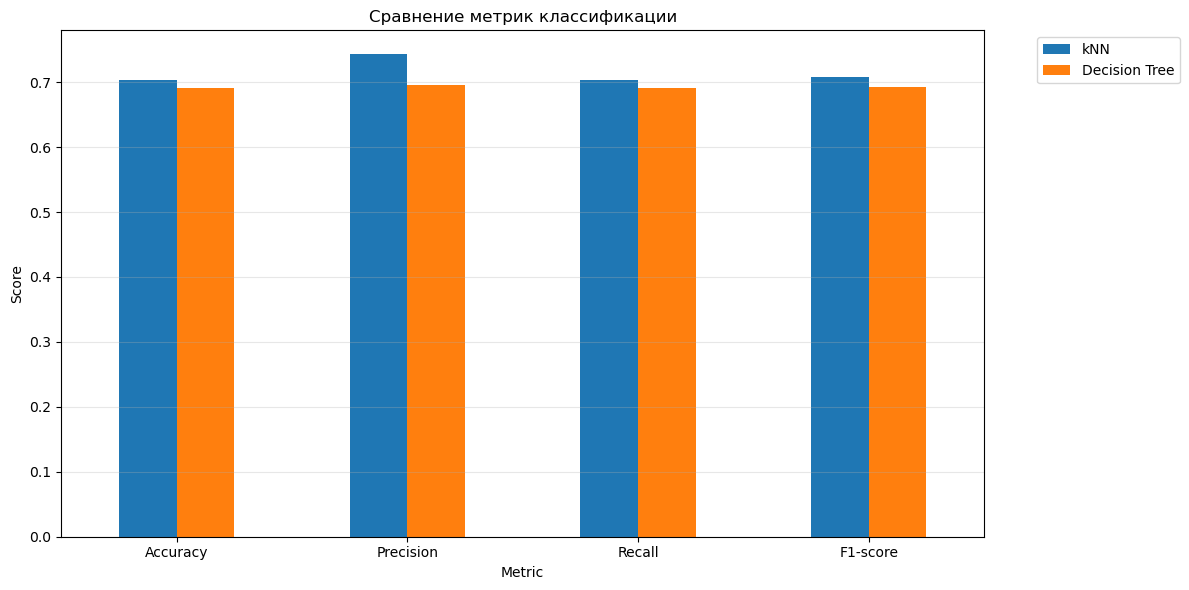

In [70]:
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'kNN': [
        accuracy_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_knn, average='weighted'),
        recall_score(y_test, y_pred_knn, average='weighted'),
        f1_score(y_test, y_pred_knn, average='weighted')
    ],
    'Decision Tree': [
        accuracy_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted')
    ]
})

display(metrics_comparison)

metrics_comparison.set_index('Metric').plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение метрик классификации')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

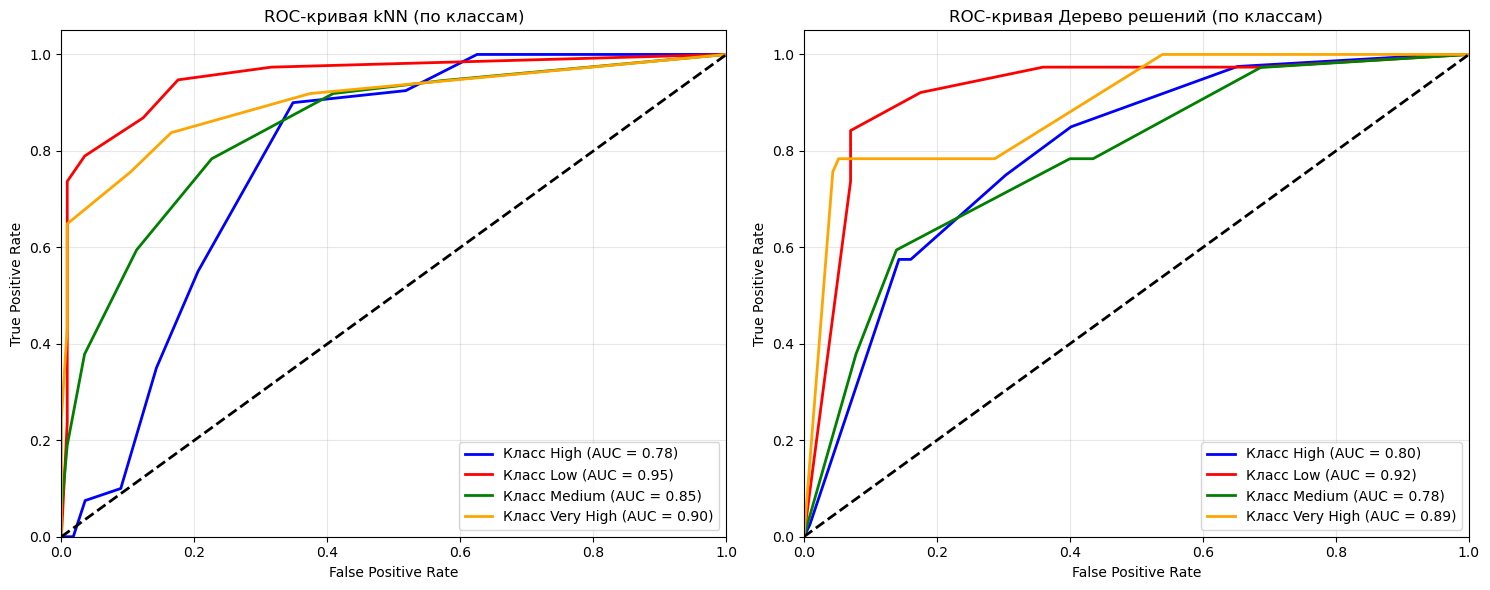

Макро-усредненный AUC kNN: 0.8712
Макро-усредненный AUC Дерево решений: 0.8479


In [74]:
from itertools import cycle

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC для kNN
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
n_classes = len(le.classes_)

for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test == i, y_prob_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr_knn[i], tpr_knn[i], color=color, lw=2,
             label='Класс {0} (AUC = {1:0.2f})'.format(le.classes_[i], roc_auc_knn[i]))

ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-кривая kNN (по классам)')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# ROC для дерева решений
fpr_dt = dict()
tpr_dt = dict()
roc_auc_dt = dict()

for i in range(n_classes):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test == i, y_prob_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr_dt[i], tpr_dt[i], color=color, lw=2,
             label='Класс {0} (AUC = {1:0.2f})'.format(le.classes_[i], roc_auc_dt[i]))

ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-кривая Дерево решений (по классам)')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

macro_auc_knn = np.mean(list(roc_auc_knn.values()))
macro_auc_dt = np.mean(list(roc_auc_dt.values()))
print(f"Макро-усредненный AUC kNN: {macro_auc_knn:.4f}")
print(f"Макро-усредненный AUC Дерево решений: {macro_auc_dt:.4f}")

## Вывод

В ходе анализа набора данных Boston Housing, отражающего характеристики жилых районов пригородов Бостона, были построены и сравнены две модели классификации — k-ближайших соседей (kNN) и дерево решений (Decision Tree). По результатам расчёта метрик качество классификации у модели kNN оказалось немного выше: точность составила 0.7039 против 0.6908 у дерева решений, а макроусреднённый показатель AUC — 0.8712 против 0.8479 соответственно. Это говорит о том, что модель kNN лучше различает классы и в целом демонстрирует более стабильные результаты на данном наборе данных. Однако разница между моделями невелика, что указывает на сопоставимую эффективность обоих подходов при решении задачи классификации объектов недвижимости.